## Problem description: The goal is to predict the operating condition of a waterpoint for each record in the dataset


## Carga de datos

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# Training set values
url1 = 'https://drive.google.com/uc?export=download&id=1Pg1qZsJVZhq86dp-CEdDJAt3Grv7wqyE'

# Training set labels
url2 = 'https://drive.google.com/uc?export=download&id=1XLIAbZ2-Jd_vdryFEn4NFnDjrWGgyDjM'

# Test set values
url3 = 'https://drive.google.com/uc?export=download&id=1WcgyWzuDQIXPtfsjO9bqottQ_tZdfjAv'

# Lectura de datos de entrenamiento variables independientes
df_x = pd.read_csv(url1)
# Lectura de datos de entrenamiento (variable objetivo)
df_y = pd.read_csv(url2)
# Lectura de datos de test variables independientes
df_x_test = pd.read_csv(url3)

In [ ]:
# revisar que no hayan registros duplicados
df_x.id.duplicated().any(), df_y.id.duplicated().any()

(False, False)

No hay registros duplicados, continuamos

In [ ]:
# Unión de variables
df = df_y.merge(df_x, on='id')
df.pop('id')
# df.set_index('status_group', inplace=True)
df

,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,functional,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,...,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
59396,functional,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,...,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
59397,functional,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,...,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
59398,functional,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,...,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump


## Preprocesado rápido y modelo!

### El objetivo del preprocesado rápido es pasar todo a numérico y hacer una primera aproximación con algún modelo para luego profundizar en el preprocesado (feature engineering) e ir mirando cómo va subiendo el score en función de cuánto más vamos profundizando en el preprocesado.

### Utilizar LabelEncoder para tener todo en numérico

In [ ]:
from sklearn.preprocessing import LabelEncoder

print('''Ejemplo de uso
Suponiendo df como tu DataFrame
df_encoded = label_encode_categorical(df)''')

def label_encode_categorical(df):
    # Crear una copia del DataFrame para no modificar el original
    encoded_df = df.copy()

    # Iterar sobre cada columna
    for col in encoded_df.columns:
        # Verificar si la columna es de tipo objeto (categórica)
        if encoded_df[col].dtype == 'object':
            # Crear un objeto LabelEncoder
            label_encoder = LabelEncoder()
            # Ajustar y transformar la columna
            encoded_df[col] = label_encoder.fit_transform(encoded_df[col])

    return encoded_df

Ejemplo de uso
Suponiendo df como tu DataFrame
df_encoded = label_encode_categorical(df)


In [ ]:
df_encoded = label_encode_categorical(df)
# df_encoded.head()

### Partición del dataset (train_test_split)

In [ ]:
from sklearn.model_selection import train_test_split

def split_train_test(df, target_column='status_group', test_size=0.2, random_state=0):
    """
    Divide el DataFrame en conjuntos de entrenamiento y prueba.

    Args:
    df_encoded (pd.DataFrame): DataFrame que contiene las características y la variable objetivo.
    target_column (str): Nombre de la columna de la variable objetivo. Default es 'status_group'.
    test_size (float): Proporción del conjunto de datos a incluir en el conjunto de prueba. Default es 0.2.
    random_state (int): Controla la aleatoriedad del muestreo. Default es 0.

    Returns:
    tuple: Contiene los conjuntos X_train, X_test, y_train, y_test.
    """
    global X
    global y

    X = df.drop(target_column, axis=1)
    y = df[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=test_size, random_state=random_state)

    # Comprobamos dimensiones
    print('Training dataset shape:', X_train.shape, y_train.shape)
    print('Testing dataset shape:', X_test.shape, y_test.shape)

    return X_train, X_test, y_train, y_test

print('Ejemplo de uso:\
X_train, X_test, y_train, y_test = split_train_test(df_encoded)')

Ejemplo de uso:X_train, X_test, y_train, y_test = split_train_test(df_encoded)


In [ ]:
X_train, X_test, y_train, y_test = split_train_test(df_encoded)

Training dataset shape: (47520, 39) (47520,)
Testing dataset shape: (11880, 39) (11880,)


### Selección de modelo, entrenamiento y evaluación

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8161616161616162

Pues funciona muy bien para una primera aproximación

### Hacemos validación cruzada para tener una idea, tal vez, más acercada de la realidad

In [ ]:
from sklearn.model_selection import cross_val_score

# Realizar la validación cruzada
scores = cross_val_score(model, X_test, y_test, cv=10)

# Mostrar los resultados de la validación cruzada
print("Puntajes de validación cruzada: ", scores)
print("Media de los puntajes: ", np.mean(scores))
print("Desviación estándar de los puntajes: ", np.std(scores))

Puntajes de validación cruzada:  [0.76767677 0.79713805 0.76851852 0.77104377 0.77020202 0.7962963
 0.79124579 0.77946128 0.78198653 0.76430976]
Media de los puntajes:  0.7787878787878787
Desviación estándar de los puntajes:  0.011753205168826305


#### Entrenamos con todo el dataset para hacer nuestro primer submission

In [ ]:
model = RandomForestClassifier()
model.fit(X,y)

RandomForestClassifier()

In [ ]:
x_test = label_encode_categorical(df_x_test.drop('id', axis=1))
y_predict = model.predict(x_test)
y_predict.shape

(14850,)

In [ ]:
submission = pd.DataFrame({'id': df_x_test['id'], 'status_group': y_predict})
submission['status_group'] = submission['status_group'].replace({0: 'functional', 1: 'functional needs repair', 2: 'non functional'})
submission.to_csv('submission.csv', index=False)

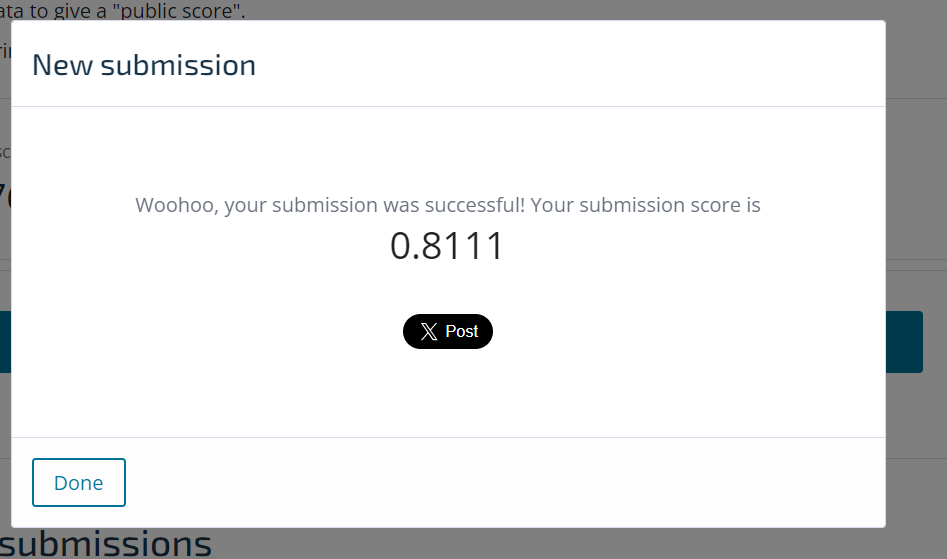

Demasiado bien para empezar. Sabemos que no será superior a un 0.82

In [ ]:
# Probamos con el modelo XGBoost
from xgboost import XGBClassifier

# Crear el modelo XGBoost
xgb_model = XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)
xgb_model.score(X_train, y_train)

0.8590909090909091

Pues muy bien también. Aparentenemente mejor que el Random Forest

In [ ]:
from sklearn.model_selection import cross_val_score

# Realizar la validación cruzada
scores = cross_val_score(xgb_model, X_test, y_test, cv=10)

# Mostrar los resultados de la validación cruzada
print("Puntajes de validación cruzada: ", scores)
print("Media de los puntajes: ", np.mean(scores))
print("Desviación estándar de los puntajes: ", np.std(scores))

Puntajes de validación cruzada:  [0.76767677 0.78282828 0.76094276 0.76262626 0.77356902 0.78282828
 0.77693603 0.79040404 0.78114478 0.77020202]
Media de los puntajes:  0.7749158249158249
Desviación estándar de los puntajes:  0.009114261066423697


En validación cruzada baja por debajo del Random Forest, así que nos quedamos con este último por ahora

## Feature Engineering

### EDA

#### Descripción de las variables

| Columna                  | Descripción                                            |
|--------------------------|--------------------------------------------------------|
| amount_tsh               | Cantidad de agua disponible en el punto de agua |
| date_recorded            | La fecha en que se ingresó la fila                    |
| funder                   | Quién financió el pozo                                 |
| gps_height               | Altitud del pozo                                       |
| installer                | Organización que instaló el pozo                       |
| longitude                | Coordenada GPS longitud                                |
| latitude                 | Coordenada GPS latitud                                 |
| wpt_name                 | Nombre del punto de agua si lo hay                     |
| num_private              | -                                                      |
| basin                    | Cuenca hidrográfica geográfica                         |
| subvillage               | Ubicación geográfica                                   |
| region                   | Ubicación geográfica                                   |
| region_code              | Ubicación geográfica (codificada)                      |
| district_code            | Ubicación geográfica (codificada)                      |
| lga                      | Ubicación geográfica                                   |
| ward                     | Ubicación geográfica                                   |
| population               | Población alrededor del pozo                           |
| public_meeting           | Verdadero/Falso                                        |
| recorded_by              | Grupo que ingresa esta fila de datos                   |
| scheme_management        | Quién opera el punto de agua                           |
| scheme_name              | Quién opera el punto de agua                           |
| permit                   | Si el punto de agua está permitido                     |
| construction_year        | Año en que se construyó el punto de agua               |
| extraction_type          | Tipo de extracción que utiliza el punto de agua        |
| extraction_type_group    | Tipo de extracción que utiliza el punto de agua        |
| extraction_type_class    | Tipo de extracción que utiliza el punto de agua        |
| management               | Cómo se administra el punto de agua                   |
| management_group         | Cómo se administra el punto de agua                   |
| payment                  | Lo que cuesta el agua                                  |
| payment_type             | Lo que cuesta el agua                                  |
| water_quality            | La calidad del agua                                    |
| quality_group            | La calidad del agua                                    |
| quantity                 | La cantidad de agua                                    |
| quantity_group           | La cantidad de agua                                    |
| source                   | La fuente del agua                                     |
| source_type              | La fuente del agua                                     |
| source_class             | La fuente del agua                                     |
| waterpoint_type          | El tipo de punto de agua                               |
| waterpoint_type_group    | El tipo de punto de agua                               |


#### Pandas Profiling Report

In [ ]:
# !pip install ydata_profiling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 359.5/359.5 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 15.2 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27080 sha256=f75de292d585fac062a48c617e650fa53d3081fe6979d34bf215ebcacd038124
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin


In [ ]:
import ydata_profiling
ydata_profiling.ProfileReport(df)

Output hidden; open in https://colab.research.google.com to view.

En el presente análisis, hemos observado un 2% de datos faltantes dentro del conjunto, el cual está compuesto por un total de 40 variables. Es importante destacar que nuestra variable objetivo presenta un desbalance significativo, aspecto que será considerado durante la selección del modelo.

Asimismo, se ha identificado que numerosas variables presentan problemas asociados con valores cero. Además, se ha detectado una alta correlación entre las variables independientes, mientras que la correlación con la variable objetivo es escasa. Esta baja correlación con la variable objetivo puede representar un obstáculo en el modelado, ya que sugiere relaciones débiles entre las variables explicativas y la variable de interés.

Al examinar las variables más influyentes, se destaca la importancia de la calidad del agua, el tipo de punto de agua (waterpoint type) y su agrupación (waterpoint type group). De manera similar, los tipos de extracción (extraction type, extraction type class, extraction type group) también muestran una influencia considerable. Además, la variable de gestión (management) y las relacionadas con la cantidad (quantity y quantity group) parecen ejercer un impacto significativo en el análisis.

En resumen, estas observaciones preliminares indican que ciertas variables presentan una relación sustancial con nuestra variable objetivo y entre sí (esto último no muy bueno), lo cual será crítico para la construcción y selección del modelo predictivo.

#### Exploración visual de la variables con plotly

In [ ]:
import plotly.express as px

print('''Ejemplo de uso
Suponiendo que 'df' es tu DataFrame
plot_numeric_variables(df)
plot_categorical_variables(df)''')

def plot_numeric_variables(df):
    # Filtrar solo las variables numéricas
    numeric_df = df.select_dtypes(include=['float', 'int'])

    # Iterar sobre cada variable numérica y crear el histograma con boxplot
    for col in numeric_df.columns:
        fig = px.histogram(numeric_df, x=col, marginal="box", title=f'Histograma con Boxplot de {col}')
        fig.show()

def plot_categorical_variables(df):
    # Filtrar solo las variables no numéricas
    non_numeric_df = df.select_dtypes(exclude=['float', 'int'])

    # Iterar sobre cada variable no numérica y crear el gráfico de ocurrencias
    for col in non_numeric_df.columns:
        fig = px.histogram(df, x=col, title=f'Ocurrencias de {col}')
        fig.show()

Ejemplo de uso
Suponiendo que 'df' es tu DataFrame
plot_numeric_variables(df)
plot_categorical_variables(df)


In [ ]:
plot_numeric_variables(df)

In [ ]:
plot_categorical_variables(df)

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Suponiendo que df es tu DataFrame y cat_vars es una lista de tus variables categóricas

def cramers_v(x, y):
    """Calcula el coeficiente de V de Cramér para dos variables categóricas."""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [ ]:
cramers_v(df.status_group, df.wpt_name)

In [ ]:
df.dtypes

### Aplicando transformaciones a las variables

In [ ]:
# Antes de aplicar transformaciones, nos disponemos a hacer una copia de mi df
df_prep = df.copy()

#### Trabajando la variable fecha

In [ ]:
def preprocess_datetime(df, datetime_column):
    """
    Preprocesa una columna datetime y extrae características temporales.

    Args:
    df (pd.DataFrame): DataFrame que contiene las variables.
    datetime_column (str): Nombre de la columna datetime.

    Returns:
    pd.DataFrame: DataFrame con las nuevas características temporales y sin la columna datetime original.
    """
    df[datetime_column] = pd.to_datetime(df[datetime_column])

    # Extraer componentes temporales
    df[f'{datetime_column}_year'] = df[datetime_column].dt.year
    df[f'{datetime_column}_month'] = df[datetime_column].dt.month
    df[f'{datetime_column}_day'] = df[datetime_column].dt.day
    df[f'{datetime_column}_hour'] = df[datetime_column].dt.hour
    df[f'{datetime_column}_day_of_week'] = df[datetime_column].dt.dayofweek


    # Eliminar la columna datetime original
    df = df.drop(columns=[datetime_column])

    return df

print('Ejemplo de uso:\
df = preprocess_datetime(df, "datetime_column")')


Ejemplo de uso:df = preprocess_datetime(df, "datetime_column")


In [ ]:
df_prep = preprocess_datetime(df_prep, 'date_recorded')
df_prep['age'] = df_prep.date_recorded_year - df_prep.construction_year

#### Eliminación de variables poco significativas

In [ ]:
features_to_drop = ['date_recorded_hour', 'recorded_by', 'num_private', 'date_recorded_year',
                    'source_class', 'management_group', 'public_meeting', 'permit']

df_prep.drop(features_to_drop, axis=1, inplace=True)

#### Imputación de variables con missings

In [ ]:
# df_prep['public_meeting'].fillna(df_prep['public_meeting'].mode()[0], inplace=True)
# df_prep['scheme_management'].fillna(df_prep['scheme_management'].mode()[0], inplace=True)
# df_prep['amount_tsh'] = df_prep['amount_tsh'].replace(0, np.nan)
# # Reemplazar los valores NaN con la moda
# df_prep['amount_tsh'] = df_prep['amount_tsh'].fillna(df_prep['amount_tsh'].mode()[0])
# df_prep['scheme_name'] = df_prep['scheme_name'].fillna(df_prep['scheme_name'].mode()[0])

#### Tramificaciòn y binarizacion


In [ ]:
import pandas as pd

def aplicar_binning(dataset, num_bins=5, binning_method='uniform'):
    """
    Aplica binning a las variables numéricas en el dataset.

    Parámetros:
    dataset (pd.DataFrame): El dataset original.
    num_bins (int): El número de bins a usar para el binning.
    binning_method (str): El método de binning a usar ('uniform' o 'quantile').

    Retorna:
    pd.DataFrame: El dataset con las variables binarizadas.
    """
    dataset_binned = dataset.copy()

    # Identificar variables numéricas
    numeric_vars = dataset_binned.select_dtypes(include=['number']).columns

    for var in numeric_vars:
        if binning_method == 'uniform':
            # Binning uniforme
            dataset_binned[var] = pd.cut(dataset_binned[var], bins=num_bins, labels=False)
        elif binning_method == 'quantile':
            # Binning por cuantiles
            dataset_binned[var] = pd.qcut(dataset_binned[var], q=num_bins, labels=False)
        else:
            raise ValueError("Método de binning no soportado: use 'uniform' o 'quantile'")

    return dataset_binned


In [ ]:
df_prep_binned = aplicar_binning(df_prep)

In [ ]:
# Crear una nueva columna donde los valores distintos de cero se cambian a 1
df_prep['amount_tsh_binary'] = df_prep['amount_tsh'].apply(lambda x: 0 if x == 0 else 1)
# df_prep['gps_height_binary'] = df_prep['gps_height'].apply(lambda x: 0 if x == 0 else 1)

#### Codificación de variables categóricas nuevamente

In [ ]:
# Poner en punta para lanzar modelo
df_prep = label_encode_categorical(df_prep)
X_train, X_test, y_train, y_test = split_train_test(df_prep)

Training dataset shape: (47520, 38) (47520,)
Testing dataset shape: (11880, 38) (11880,)


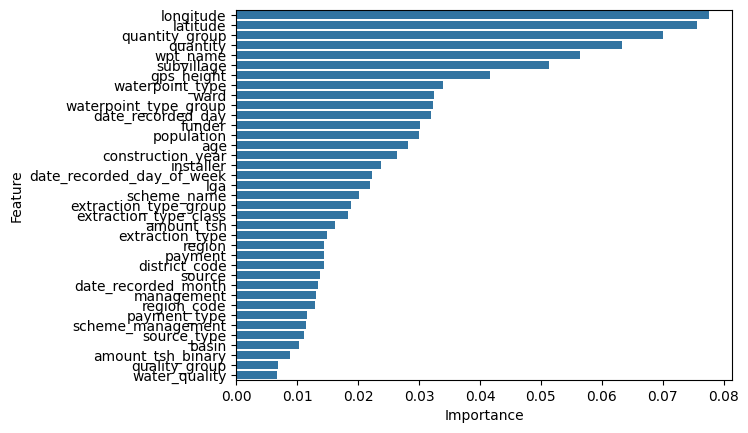

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

model_i = RandomForestClassifier()
model_i.fit(X_train, y_train)

feature_importances = model_i.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualizar las importancias
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.show()

## Modelado Final

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
model1 = RandomForestClassifier()
model1.fit(X_train, y_train)
model1.score(X_test, y_test)

0.8152356902356902

In [ ]:
from sklearn.model_selection import cross_val_score

# Realizar la validación cruzada
scores = cross_val_score(model1, X_test, y_test, cv=10)

# Mostrar los resultados de la validación cruzada
print("Puntajes de validación cruzada: ", scores)
print("Media de los puntajes: ", np.mean(scores))
print("Desviación estándar de los puntajes: ", np.std(scores))

Puntajes de validación cruzada:  [0.77272727 0.78619529 0.76851852 0.77609428 0.76683502 0.78367003
 0.7979798  0.77861953 0.77272727 0.76767677]
Media de los puntajes:  0.777104377104377
Desviación estándar de los puntajes:  0.009333950353959012


In [ ]:
# Poner en punta para lanzar modelo
df_prep = label_encode_categorical(df_prep)
X_train, X_test, y_train, y_test = split_train_test(df_prep)

Training dataset shape: (47520, 37) (47520,)
Testing dataset shape: (11880, 37) (11880,)


In [ ]:
model_i.fit(X,y)

RandomForestClassifier()

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier

# Define los parámetros
params = {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 880}

# Crea el clasificador Random Forest con los parámetros especificados
model2 = RandomForestClassifier(**params)
model2.fit(X, y)

CPU times: user 3min 11s, sys: 1.32 s, total: 3min 12s
Wall time: 3min 13s


RandomForestClassifier(criterion='entropy', min_samples_split=5,
                       n_estimators=880)

In [ ]:
y.value_counts()

status_group
0    32259
2    22824
1     4317
Name: count, dtype: int64

In [ ]:
%%time

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Estrategias de muestreo para cada clase
under_sampling_strategy = {0: 15000, 2: 15000, 1: 4317}
over_sampling_strategy = {0: 15000, 2: 15000, 1: 15000}

pipeline = Pipeline([
    ('under', RandomUnderSampler(sampling_strategy=under_sampling_strategy)),
    ('smote', SMOTE(sampling_strategy=over_sampling_strategy)),
    ('model', model2)
])

pipeline.fit(X, y)

CPU times: user 2min 31s, sys: 1.1 s, total: 2min 32s
Wall time: 2min 33s


Pipeline(steps=[('under',
                 RandomUnderSampler(sampling_strategy={0: 15000, 1: 4317,
                                                       2: 15000})),
                ('smote',
                 SMOTE(sampling_strategy={0: 15000, 1: 15000, 2: 15000})),
                ('model',
                 RandomForestClassifier(criterion='entropy',
                                        min_samples_split=5,
                                        n_estimators=880))])

Para el submuestreo, reduciremos las clases 0 y 2 a un número intermedio.
Para el sobremuestreo, aumentaremos la clase 1 para que sea comparable a las otras clases.


In [ ]:
# Poner en punta el test para que coincida con el entrenamiento del modelo
df_x_test = pd.read_csv(url3)
df_x_test = preprocess_datetime(df_x_test, 'date_recorded')
df_x_test['age'] = df_x_test.date_recorded_year - df_x_test.construction_year
df_x_test['amount_tsh_binary'] = df_x_test['amount_tsh'].apply(lambda x: 0 if x == 0 else 1)
# df_prep['gps_height_binary'] = df_prep['gps_height'].apply(lambda x: 0 if x == 0 else 1)

df_x_test.drop(features_to_drop, axis=1, inplace=True)

In [ ]:
# Sin balanceo
x_test = label_encode_categorical(df_x_test.drop('id', axis=1))
y_predict = model2.predict(x_test)
y_predict.shape

(14850,)

In [ ]:
# Pipeline de balanceo
x_test = label_encode_categorical(df_x_test.drop('id', axis=1))
y_predict = pipeline.predict(x_test)
y_predict.shape

(14850,)

In [ ]:
submission = pd.DataFrame({'id': df_x_test['id'], 'status_group': y_predict})
submission['status_group'] = submission['status_group'].replace({0: 'functional', 1: 'functional needs repair', 2: 'non functional'})
submission.to_csv('submission.csv', index=False)

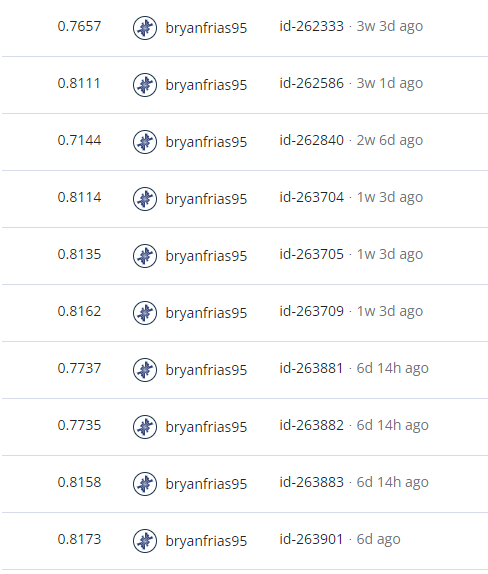

### Proceso de Optimización del Dataset y Modelado en Machine Learning

Durante el proceso iterativo de prueba y error, que incluyó transformaciones en el dataset mediante preprocesamiento y la posterior búsqueda de modelos, se logró identificar las variables óptimas para eliminar del dataset. Este proceso implicó pruebas eliminando diferentes cantidades de variables y observando la incidencia en el modelo Random Forest mediante la importancia de las características (Feature Importance). Gradualmente, se eliminaron variables hasta alcanzar una configuración adecuada, eliminando aquellas consideradas como ruido.

### Imputación de Valores Nulos

Se intentaron varias técnicas de imputación para las variables con muchos valores nulos, incluso transformando valores cero a nulos y luego imputando. Sin embargo, todos estos intentos resultaron en modelos significativamente inferiores en comparación con los modelos anteriores. A pesar de que estos procedimientos se documentaron, no se obtuvo ningún resultado interesante de este proceso.

### Creación de Nuevas Variables

Se intentó también la creación de nuevas variables mediante binarización. Este enfoque mostró una leve mejora en el rendimiento del modelo. Específicamente, se creó una nueva variable binaria a partir de `amount_tsh`, debido a la alta cantidad de ceros presentes en la variable original.

### Optimización de Hiperparámetros mediante Grid Search

Se realizó un Grid Search para optimizar los hiperparámetros del modelo. Inicialmente, se efectuó una búsqueda manual, determinando varios aspectos clave:

- El mejor criterio fue el de Entropía.
- La profundidad máxima se estableció en `None`.
- El valor de `min_sample_split` se fijó en 5.

Estos parámetros se identificaron a través de un Grid Search inicial con rangos pequeños. En cuanto al número de estimadores, se observó que aumentar la cantidad incrementaba la precisión del modelo hasta un cierto punto, después del cual la precisión comenzaba a decrecer. Finalmente, se encontró que el número óptimo de estimadores era 880, siendo este el parámetro más complicado de ajustar. El criterio de Entropía resultó ser bastante robusto frente a los desbalances en el dataset.

### Intentos de Balanceo del Dataset

Se intentó balancear el dataset, pero este intento también resultó en una disminución significativa del rendimiento del modelo. Por lo tanto, aunque este proceso se documentó, su implementación no fue efectiva.

### Resultados Finales

El modelo final alcanzó un valor de precisión aceptable de 0.8173, aunque se aspiraba a obtener un rendimiento superior. A pesar de los diversos métodos y ajustes realizados, este fue el resultado más óptimo logrado en el proceso.

# Miscelanea

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define los parámetros
params = {'criterion': 'entropy''n_estimators':[75,150, 200],
              'max_depth':[2,5,10,None],
              'min_samples_split':[2,5,10]}

# Crea el clasificador Random Forest con los parámetros especificados
rf = RandomForestClassifier(**params)

rfc_params = {'n_estimators':[75,150, 200],
              'max_depth':[2,5,10,None],
              'min_samples_split':[2,5,10]}


grid_rfc = GridSearchCV(RandomForestClassifier(),
                        rfc_params,
                        cv=5,
                        scoring='recall').fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 2098, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1573, in precision_recall_fscore_support
    labels = _check

CPU times: user 26min 50s, sys: 5.44 s, total: 26min 56s
Wall time: 27min 5s


In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier

# Define los parámetros
params = {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 880}

# Crea el clasificador Random Forest con los parámetros especificados
model2 = RandomForestClassifier(**params)
model2.fit(X_train, y_train)
print(model2.score(X_test, y_test), params)

0.8180976430976431 {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 880}
CPU times: user 2min 36s, sys: 894 ms, total: 2min 37s
Wall time: 2min 37s


In [ ]:
%%time

from sklearn.model_selection import GridSearchCV
rfc_params = {'n_estimators':[75,150, 200],
              'max_depth':[2,5,10,None],
              'min_samples_split':[2,5,10]}


grid_rfc = GridSearchCV(RandomForestClassifier(),
                        rfc_params,
                        cv=5,
                        scoring='accuracy').fit(X_train, y_train)

In [ ]:
model2.fit(X, y)

In [ ]:
# Probamos con el modelo XGBoost
from xgboost import XGBClassifier

# Crear el modelo XGBoost
xgb_model1 = XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='mlogloss')
xgb_model1.fit(X_train, y_train)
xgb_model1.score(X_train, y_train)

In [ ]:
# ML FLOW
# random forest, gini,